In [1]:
import difflib
import math
import random
import string
random.seed(123)

import gluonnlp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf
from utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from tqdm import tqdm
from utils.expand_bounding_box import expand_bounding_box
from utils.sclite_helper import Sclite_helper
from utils.word_to_line import sort_bbs_line_by_line, crop_line_images

from paragraph_segmentation_dcnn import make_cnn as ParagraphSegmentationNet, paragraph_segmentation_transform
from word_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform, alphabet_dict
from handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

In [2]:
ctx = mx.gpu(1)

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results. Randomly select 4 images for analysis.

In [3]:
test_ds = IAMDataset("form_original", train=False)

In [4]:
figs_to_plot = 4
images = []

for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    #n = [6, 17, 21, 27][i]
    image, _ = test_ds[n]
    images.append(image)

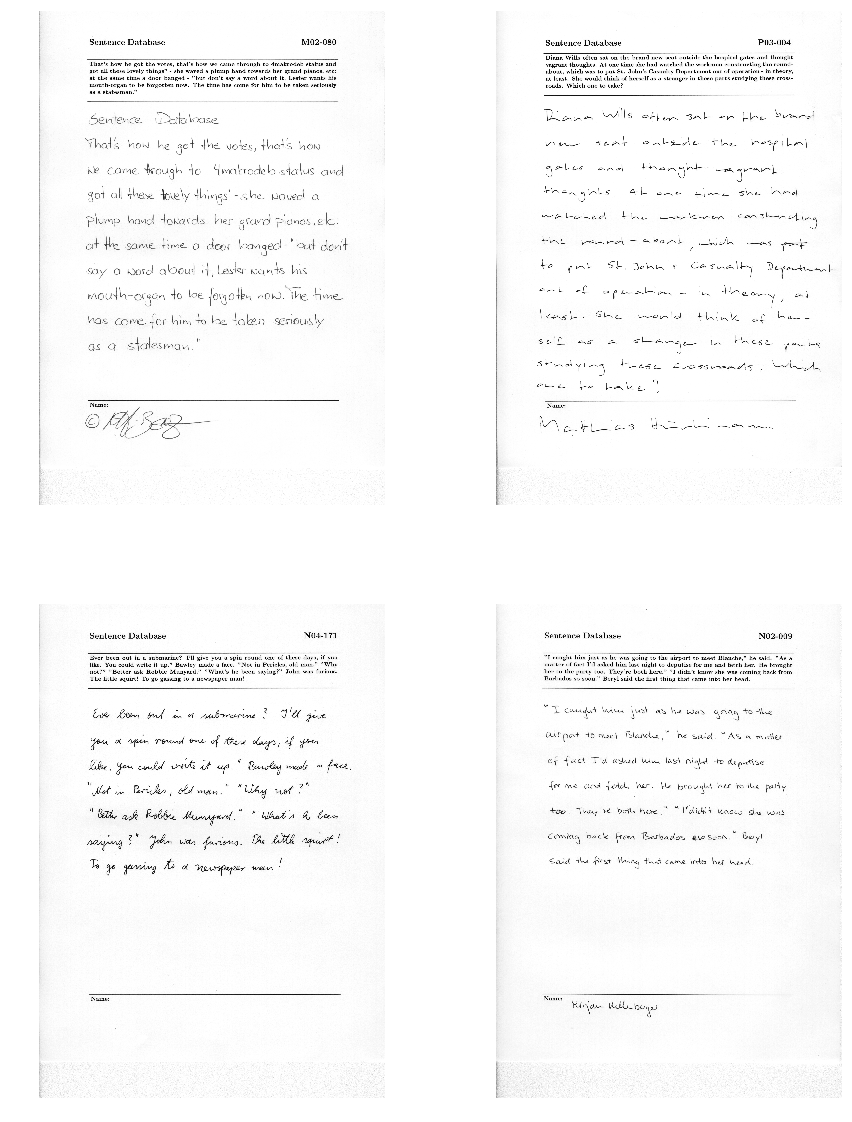

In [5]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

## Paragraph segmentation
Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component. The model was trained on using https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.py and an example is presented in https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.ipynb

In [6]:
paragraph_segmentation_net = ParagraphSegmentationNet(ctx)
paragraph_segmentation_net.load_parameters("models/paragraph_segmentation2.params", ctx)

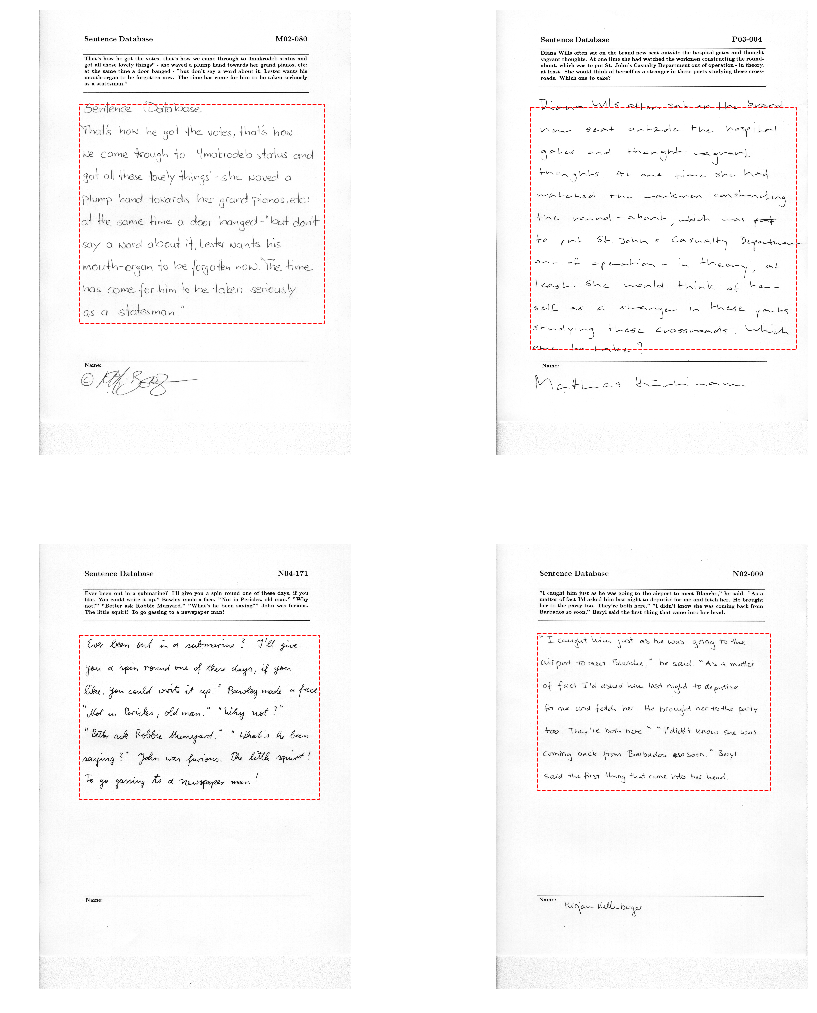

In [7]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    
    bb_predicted = bb_predicted[0].asnumpy()

    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

#### Image processing
Crop the handwriting component out of the original IAM form.

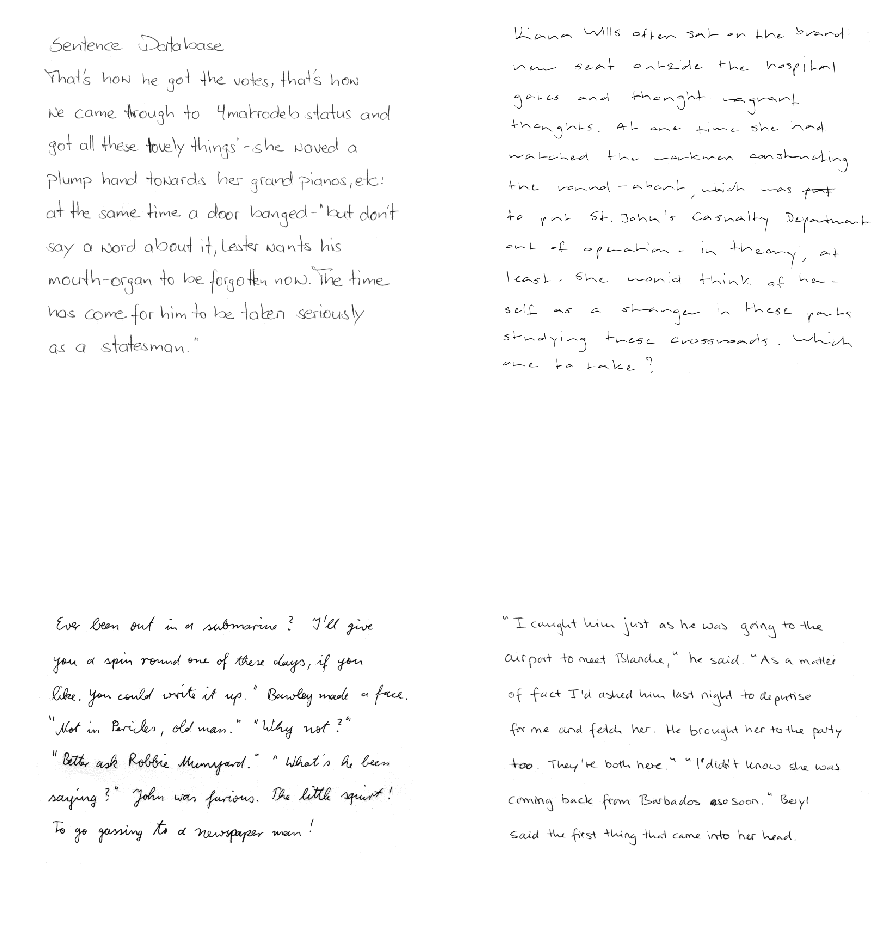

In [8]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

## Line/word segmentation
Given a form with only handwritten text, predict a bounding box for each word. The model was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/word_segmentation.py

In [9]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation.params")

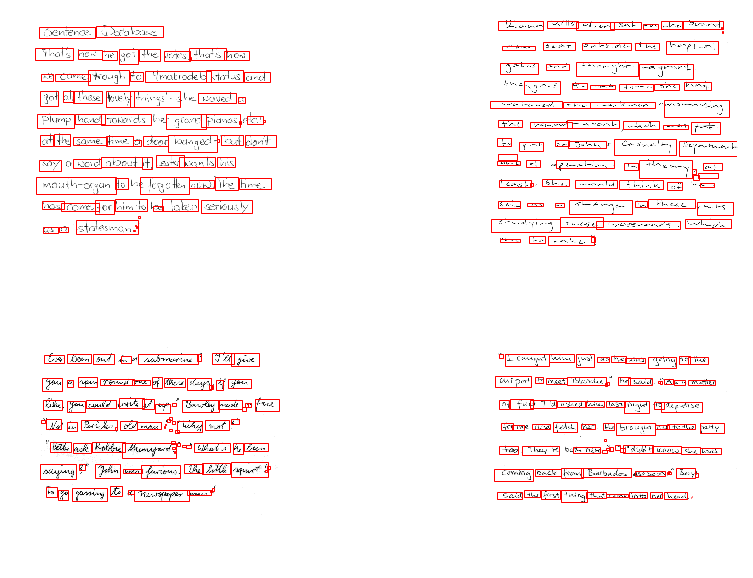

In [10]:
min_c = 0.01
overlap_thres = 0.001
topk = 400

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)
    
    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')

    for j in range(predicted_bb.shape[0]):                
        (x, y, w, h) = expand_bounding_box(predicted_bb[j], expand_bb_scale_x=0.2,
                                           expand_bb_scale_y=0.01)
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

#### Word to line image processing
Algorithm to sort then group all words within a line together.

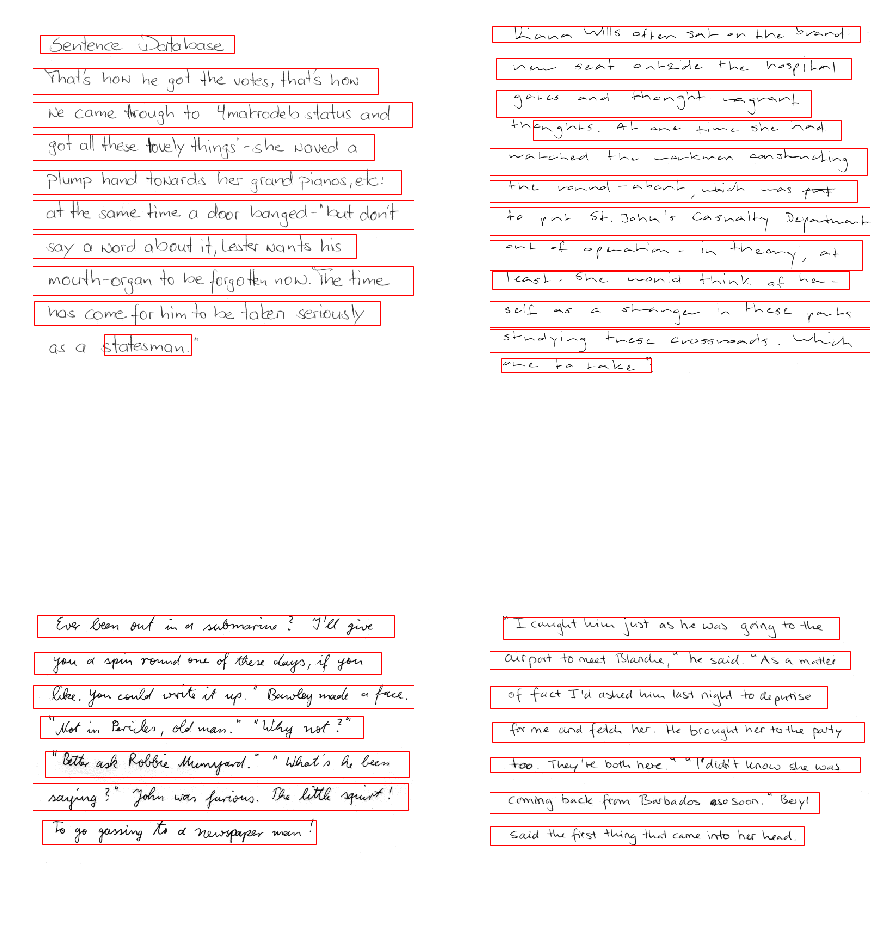

In [11]:
line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

# Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [12]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line_sl_160_a_512_o_2.params")

In [13]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

### Language model

```
To be redone, check git history if needed
```

In [14]:
from utils.CTCDecoder.BeamSearch import ctcBeamSearch
from utils.CTCDecoder.LanguageModel import LanguageModel

In [15]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [16]:
def get_beam_search(prob, width=20, k=4):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width, k)
    return possibilities[0]

In [17]:
def get_beam_search_with_lm(prob, width=20, k=4):
    lm = LanguageModel('dataset/alicewonder.txt', alphabet_encoding)
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, lm, width, k)
    return possibilities[0]

#### Using denoiser

In [88]:
from utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=150, max_tgt_length=150, num_heads=4, embed_size=256, num_layers=2)
denoiser.load_parameters('model_checkpoint/denoiser.params', ctx=ctx)
#denoiser.hybridize(static_alloc=True)

In [89]:
def denoise(denoiser, sentence):
    src_seq, src_valid_length = encode_char(sentence)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)

    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = []
    for i in range(0,150):
        next_input, states = denoiser.decode_logprob(inputs, states)
        inputs = next_input.argmax(axis=1)
        if inputs == EOS: 
            break
        output.append(int(inputs.asscalar()))
    output.append(int(inputs.asscalar()))
    return decode_char(output)

In [90]:
def get_denoised(prob):
    text = get_arg_max(prob)
    print(text)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    text = generate_sequences(beam_sampler, inputs, states)
    print(text)
    return text

# Qualitative results
The handwriting is recognised for the four randomly selected forms. The results from the three methods: no language model, lexicon search, and beam search are presented.

#### No language model

In [ ]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(9, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_arg_max(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

### Using Denoiser

bentence Database
bentence at a base
sentence at a base
be notence at a base
bentence but a base
sentence but a base
tentence at a base
bendence at a base
gentence at a base
bentence at a based
benience at a base
bentance at a base
sentence at a based
bentence at a basen
sentence at a basen
bentence at a bade
bentence at a bases
sentence at a bare
bentence at a bare
bentence but abase
bentence by a base
sentence at a bade
sentence by a base
bentence at a baser
sentence at a baser
bentence Database
sentence Database
bentence at abase
sentence but abase
bentence Dalabase
sentence Dalabase
sentence but abase
That's how he got the votes, that's how
That's how he got the votes, that's how
That's how he got the votes, that's how how
That's how he got the votes, that's low
That's how he got the votes, that's now
That's how he got the votest, that's how
What's how he got the votes, that's how
That's how he got the votes, that 's how
That's how she got the votes, that's how
That's how he got th

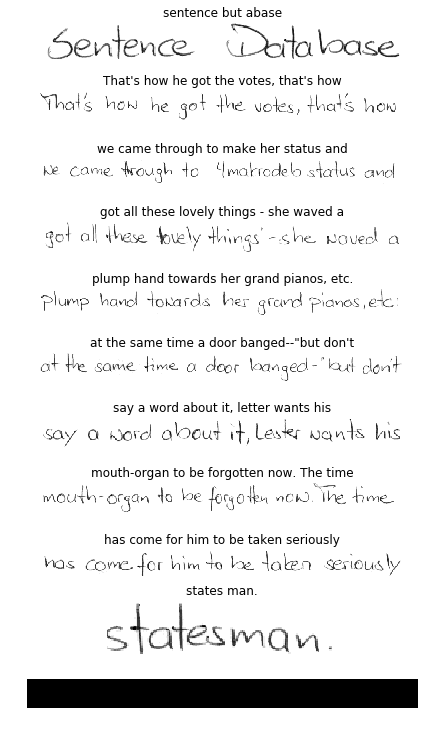

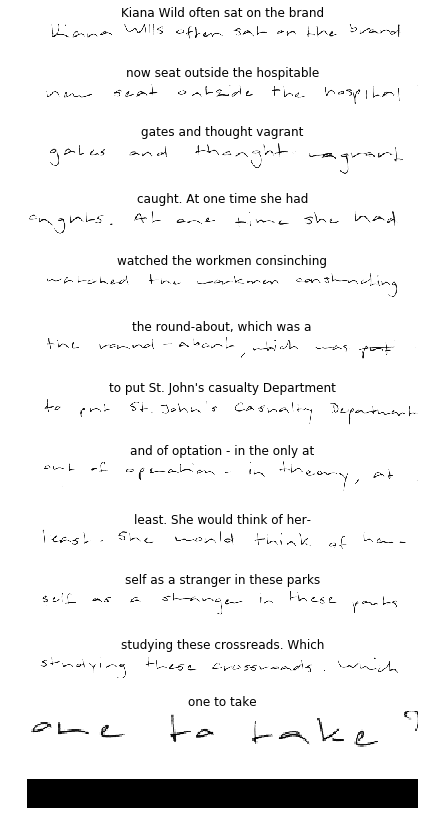

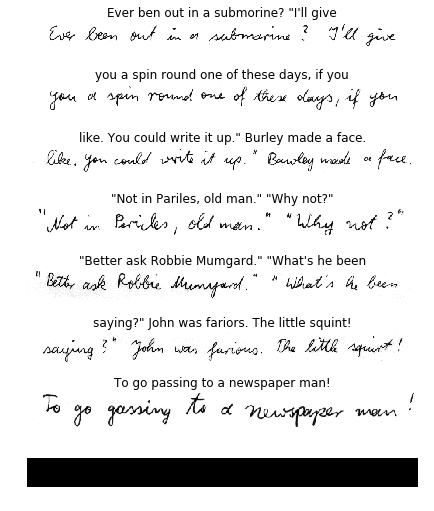

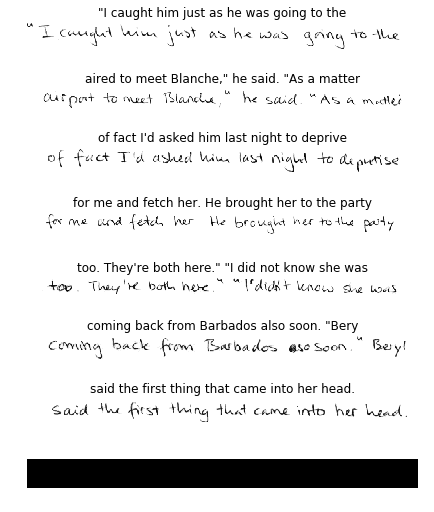

In [91]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_denoised(line_character_probs)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

### Adding Beam Search inference

In [ ]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_beam_search(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

### Adding Beam Search inference + Language Model

In [ ]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_beam_search_with_lm(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

# Quantitative Results
Iterative through the test data with the previous tests to obtain the total Character Error Rate (CER).

In [164]:
sclite = Sclite_helper()

def get_qualitative_results(denoise_func):
    sclite.clear()
    for i in tqdm(range(len(test_ds))):
        image, text = test_ds[i]
        resized_image = paragraph_segmentation_transform(image, image_size=(1120, 800))
        paragraph_bb = paragraph_segmentation_net(resized_image.as_in_context(ctx))
        paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb[0].asnumpy(), image_size=(800, 800))
        word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)
        line_bbs = sort_bbs_line_by_line(word_bb)
        line_images = crop_line_images(paragraph_segmented_image, line_bbs)

        predicted_text = []
        for line_image in line_images:
            line_image = handwriting_recognition_transform(line_image, line_image_size)
            character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
            decoded_text = denoise_func(character_probabilities)
            predicted_text.append(decoded_text)

        actual_text = text[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"')[:-1]
        actual_text = actual_text.split("\n")
        if len(predicted_text) > len(actual_text):
            predicted_text = predicted_text[:len(actual_text)]
        sclite.add_text(predicted_text, actual_text)
    
    _, er = sclite.get_cer()
    print("Mean CER = {}".format(er))

In [ ]:
get_qualitative_results(get_arg_max)

In [ ]:
get_qualitative_results(get_beam_search)

In [ ]:
get_qualitative_results(get_beam_search_with_lm)

In [ ]:
get_qualitative_results(get_denoised)

In [36]:
import gluonnlp as nlp

In [72]:
text_filepath = 'dataset/typo/all.txt'
text_lines = [l.replace('\n','').replace('`','"').replace('--',' -- ').strip() for l in open(text_filepath, 'r', encoding='Latin-1').readlines() if l != "''"]
full_text = ' '.join(text_lines)
tokenizer = nlp.data.transforms.NLTKMosesTokenizer()
tokens = tokenizer(full_text[:9999999])
counter = nlp.data.Counter(tokens)
vocab = nlp.Vocab(counter, unknown_token='<UNK>', padding_token='<PAD>',
                  bos_token='<BOS>', eos_token='<EOS>', min_freq=1)

In [73]:
len(vocab)

44116

In [38]:
scorer = nlp.model.BeamSearchScorer(alpha=0, K=5, from_logits=False)

In [39]:
def scorer(first, second, third):
    print(first, second, third)
    return 1

In [40]:
eos_id = EOS
beam_sampler = nlp.model.BeamSearchSampler(beam_size=30,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=eos_id,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [85]:
def generate_sequences(sampler, inputs, begin_states):
    samples, scores, valid_lengths = sampler(inputs, begin_states)
    samples = samples[0].asnumpy()
    scores = scores[0].asnumpy()
    valid_lengths = valid_lengths[0].asnumpy()
    max_score = -10e20
    for i, sample in enumerate(samples):

        tokens = decode_char(sample[:valid_lengths[i]])
        print(tokens)
        tokens = tokens.split(' ')
        score = 0
        for t in tokens:
            if t in vocab:
                score += 1
            else:
                score -= 1
            score -= 1.5
        if score > max_score:
            max_score = score
            sentence = ' '.join(tokens)

    return sentence

In [86]:
sentence = 'To go gassing to a newspaper man'

In [87]:
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
generate_sequences(beam_sampler, inputs, states)

To go passing to a newspaper man
To go passing to a newspa paper man
To go passing to a new spaper man
To go gussing to a newspaper man
To be passing to a newspaper man
To god passing to a newspaper man
To go glassing to a newspaper man
To go passing to a newspoper man
To go massing to a newspaper man
To go passing to a newspaper many
To go ppassing to a newspaper man
To goo passing to a newspaper man
To ggo passing to a newspaper man
To go passing to a news paper man
To go gossing to a newspaper man
To go Passing to a newspaper man
To go possing to a newspaper man
To do passing to a newspaper man
To go passing to a newspaper men
To go pasting to a newspaper man
To go assing to a newspaper man
To go passing to a newsgaper man
To go tossing to a newspaper man
To go zassing to a newspaper man
To go pussing to a newspaper man
To go passing to a newspaker man
To go passing to a newspaper can
To go passing to a newspaper may
To go pasling to a newspaper man
To go passing to a newspaler man


'To go passing to a newspaper man'